## Churn Model - RandomForest

### Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [25]:
df = pd.read_csv('../database/processed/netflix_users_t100.csv')
df.head()


,Age,Subscription_Type,Watch_Time_Hours,Churn,Usage_Intensity,Is_Heavy_User,Age_Group,Country_Australia,Country_Brazil,Country_Canada,...,Country_Mexico,Country_UK,Country_USA,Favorite_Genre_Action,Favorite_Genre_Comedy,Favorite_Genre_Documentary,Favorite_Genre_Drama,Favorite_Genre_Horror,Favorite_Genre_Romance,Favorite_Genre_Sci-Fi
0,18,2,80.26,0,4.224211,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,23,2,321.75,0,13.406250,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,60,0,35.89,1,0.588361,0,3,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,44,2,261.56,0,5.812444,0,2,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,68,1,909.30,0,13.178261,1,3,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [26]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("churn-randomForest")

with mlflow.start_run(run_name="With-Type-Subscription"):
  X = df.drop(columns=['Churn'])
  y = df['Churn']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

  mlflow.sklearn.autolog()

  parameters = {
      'n_estimators': 100,
      'max_depth': 10,
      'random_state': 42,
      'class_weight': 'balanced'
  }

  rf_model = RandomForestClassifier(**parameters)
  rf_model.fit(X_train, y_train)


2025/12/21 00:27:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\davi emmerick\Projetos\churn-netflix\predictive-churn-analysis\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/21 00:27:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\

🏃 View run With-Type-Subscription at: http://127.0.0.1:5000/#/experiments/3/runs/e6b64b5096214451ab81bf21f26b3a81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


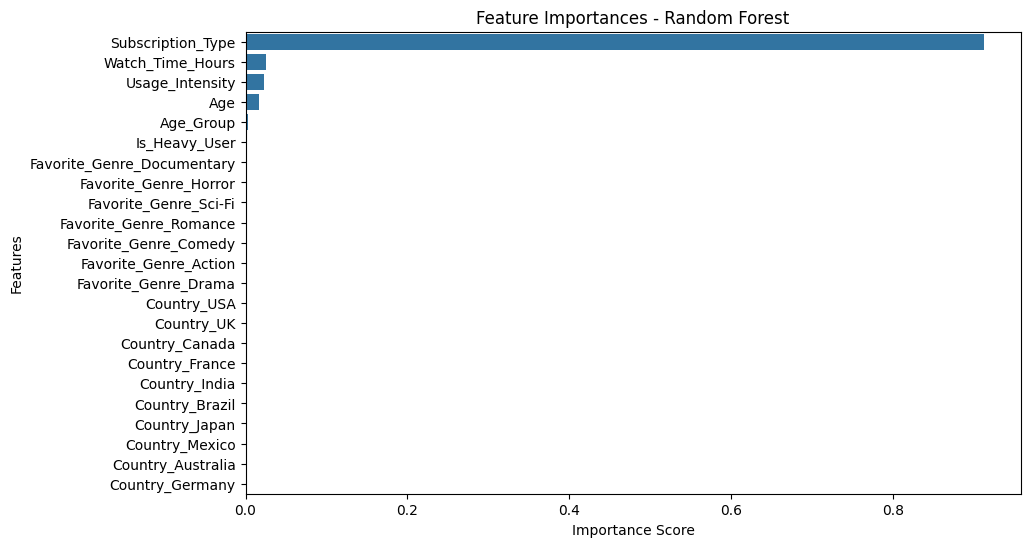

In [27]:
importance = rf_model.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importances - Random Forest')
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

#### Resolvi checar se a coluna subscription type entrega alguma regra de negócio óbvia demais. Vou repetir sem ela.

In [28]:
X_train_no_sub = X_train.drop(columns=['Subscription_Type'])
X_test_no_sub = X_test.drop(columns=['Subscription_Type'])

with mlflow.start_run(run_name="RF_Sem_Subscription"):
  params = {
        "n_estimators": 200,
        "max_depth": 10,
        "min_samples_leaf": 20,
        "class_weight": "balanced",
        "random_state": 42
    }
    
  rf_model_v2 = RandomForestClassifier(**params)
  rf_model_v2.fit(X_train_no_sub, y_train.to_numpy())
    
  y_pred = rf_model_v2.predict(X_test_no_sub)
  y_probs = rf_model_v2.predict_proba(X_test_no_sub)[:, 1]
    
  auc_novo = metrics.roc_auc_score(y_test, y_probs)
  recall_novo = metrics.recall_score(y_test, y_pred, pos_label=1)
    
  mlflow.log_params(params)
  mlflow.log_metric("roc_auc_no_sub", auc_novo)
  mlflow.log_metric("recall_no_sub", recall_novo)
    
  signature = infer_signature(X_test_no_sub, y_pred)
  mlflow.sklearn.log_model(rf_model_v2, "model_no_subscription", signature=signature)


2025/12/21 00:27:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\davi emmerick\Projetos\churn-netflix\predictive-churn-analysis\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/21 00:27:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\

🏃 View run RF_Sem_Subscription at: http://127.0.0.1:5000/#/experiments/3/runs/3af43fdea97c4a249cc85c74a95cda0d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


C:\Users\davi emmerick\AppData\Local\Temp\ipykernel_8108\3983581721.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


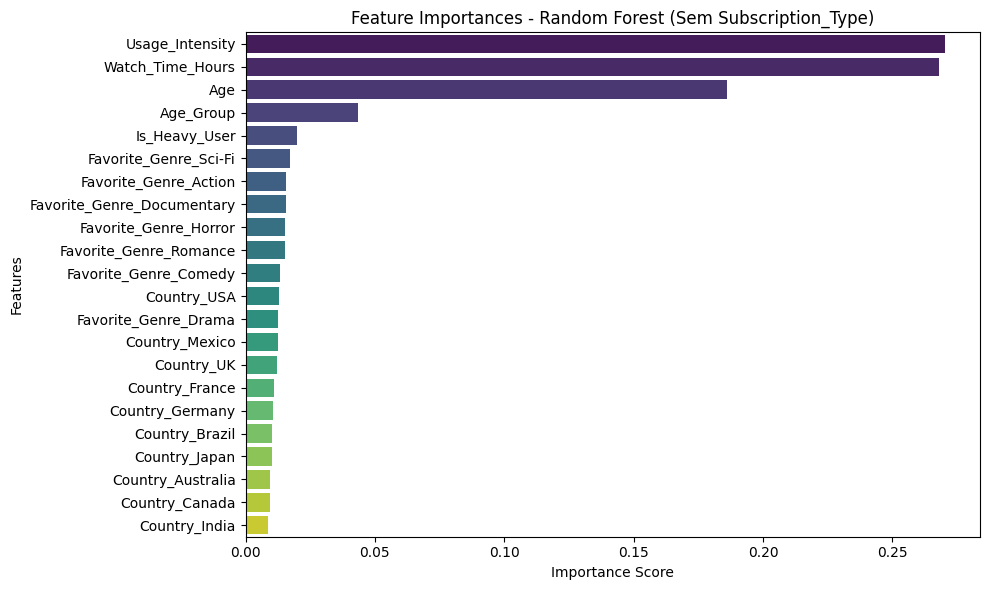

In [29]:
importance = rf_model_v2.feature_importances_
feature_names = X_train_no_sub.columns 

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Random Forest (Sem Subscription_Type)')

sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')

plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout() 
plt.show()

In [ ]:
with mlflow.start_run(run_name="RF_Tuning_Sem_Subscription"):
    X_train_no_sub = X_train.drop(columns=['Subscription_Type'])
    
    mlflow.sklearn.autolog()

    rf_base = RandomForestClassifier(class_weight="balanced", random_state=42)

    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_leaf": [10, 20, 30]
    }

    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=5, 
        scoring='f1', 
        n_jobs=-1
    )

    # O fit agora vai testar todas as combinações e fazer a Cross Validation
    grid_search.fit(X_train_no_sub, y_train)

    melhor_modelo = grid_search.best_estimator_
    
    print(f"Melhores parâmetros: {grid_search.best_params_}")

In [31]:
melhor_rf = grid_search.best_estimator_

y_pred_final = melhor_rf.predict(X_test_no_sub)
y_probs_final = melhor_rf.predict_proba(X_test_no_sub)[:, 1]

print(f"Resultados após feature engineering e tuning")
print(f"Recall:   {metrics.recall_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC:  {metrics.roc_auc_score(y_test, y_probs_final):.4f}")
print(f"F1-Score: {metrics.f1_score(y_test, y_pred_final):.4f}")

Resultados após feature engineering e tuning
Recall:   0.4271
ROC AUC:  0.5125
F1-Score: 0.3179


#### Resultado do roc caiu para 0.71, provavelmente o modelo estava usando a coluna de inscrição como muleta para dar churn, ao invés de analisar o comportamento do usuário. Aqui eu vou tentar alguma saída de feature engineering ou treinar um modelo mais completo